Average difference of 0.000125 with std. dev. of 0.002792.


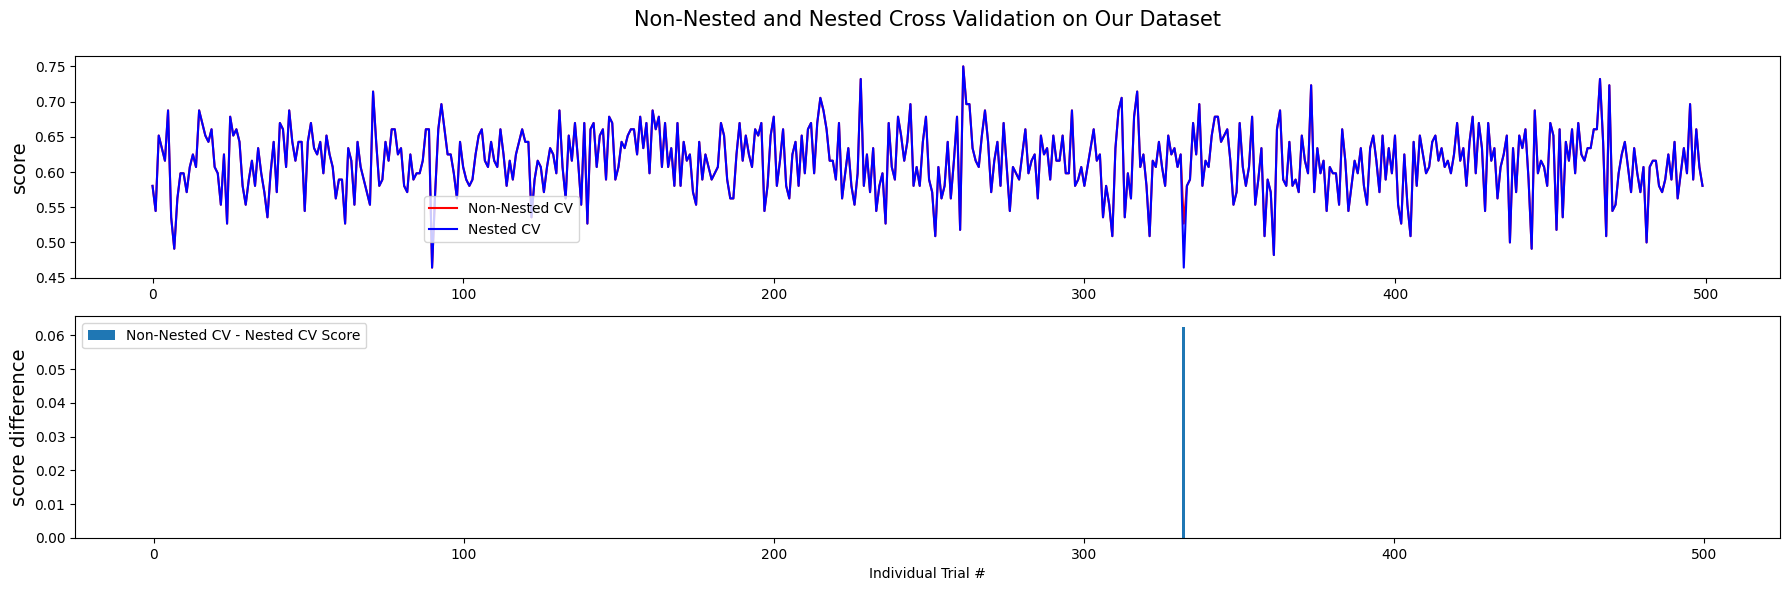

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, LeaveOneOut, ShuffleSplit

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

# Number of random trials
NUM_TRIALS = 500


data = pd.read_csv('normalized_results.csv')

# Separate numerical data: from the beginning to the 4th column before the end
numerical_data = data.iloc[:, :-4]

# Separate artist category: the 3rd column from the end
artist_category = data.iloc[:, -3]

X_iris = numerical_data
y_iris = artist_category

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
  inner_cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=i)
  outer_cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=i)
  # Non_nested parameter search and scoring
  clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
  clf.fit(X_iris, y_iris)
  non_nested_scores[i] = clf.best_score_

  # Nested CV with parameter optimization
  clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
  nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
  nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
  "Average difference of {:6f} with std. dev. of {:6f}.".format(
      score_difference.mean(), score_difference.std()
  )
)

# Plot scores on each trial for nested and non-nested CV with wider figure
plt.figure(figsize=(18, 6)) 

plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
  [non_nested_scores_line, nested_line],
  ["Non-Nested CV", "Nested CV"],
  bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
  "Non-Nested and Nested Cross Validation on Our Dataset",
  x=0.5,
  y=1.1,
  fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
  [difference_plot],
  ["Non-Nested CV - Nested CV Score"],
  bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()